In [1]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import glob
import matplotlib.patches as patches
import hdbscan as hd
from sklearn.preprocessing import StandardScaler
from hdbscan import prediction
from sklearn.cluster import HDBSCAN
from collections import Counter
from openTSNE import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from lib import plotting as p
from lib import dataprep as dp
import random
import umap
from tqdm import tqdm
from lib.evaluation import FeatureExtractor
from lib.dataloader import CustomTestDataset
import tifffile as tiff
from sklearn.utils import shuffle

/localscratch/emseg_ls/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the model

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

patch_size = 64
sample_size = 131
centre_size = 4
n_channel = 32
hierarchy_level = 3
pad_size = (patch_size - centre_size) // 2
model_dir = "/group/jug/Sheida/HVAE/Hyperparameter_search/legendary-violet-547-2nd-cl1e-3_kl1/"
model = torch.load(model_dir+"model/Contrastive_MAE_best_vae.net")

### Loading train data
### Sample from different classes
### Loading test data

In [3]:
# train data

data_dir = "/localscratch/contrastive/"
train_img_dir = sorted(glob.glob(data_dir+"train/mito_golgi_gra/*.tif"))
train_images = tiff.imread(train_img_dir)
train_label_dir = sorted(glob.glob(data_dir+"train/label_mito_golgi_gra/*.tif"))
train_labels = tiff.imread(train_label_dir)



train_images, train_labels = shuffle(train_images, train_labels)

data_mean = np.mean(train_images)
data_std = np.std(train_images)
train_images = (train_images-data_mean)/data_std
train_set = CustomTestDataset(train_images, train_labels)

golgi_indices = random.sample(train_set.patches_by_label[1],sample_size)
mito_indices = random.sample(train_set.patches_by_label[2],sample_size)
gra_indices = random.sample(train_set.patches_by_label[3],sample_size)

golgi_samples, golgi_cls, golgi_lbl = train_set[golgi_indices]
mito_samples, mito_cls, mito_lbl = train_set[mito_indices]
gra_samples, gra_cls, gra_lbl = train_set[gra_indices]

golgi_samples = golgi_samples.squeeze(1)
golgi_lbl = golgi_lbl.squeeze(1)
mito_samples = mito_samples.squeeze(1)
mito_lbl = mito_lbl.squeeze(1)
gra_samples = gra_samples.squeeze(1)
gra_lbl = gra_lbl.squeeze(1)

#test data

test_img_dir = sorted(glob.glob(data_dir+"test/mito_golgi_gra/*.tif"))
test_images = tiff.imread(test_img_dir)
test_label_dir = sorted(glob.glob(data_dir+"test/label_mito_golgi_gra/*.tif"))
test_labels = tiff.imread(test_label_dir)

test_images = (test_images-data_mean)/data_std

Extracting patches from high_c4: 100%|██████████| 505/505 [00:03<00:00, 166.25it/s]


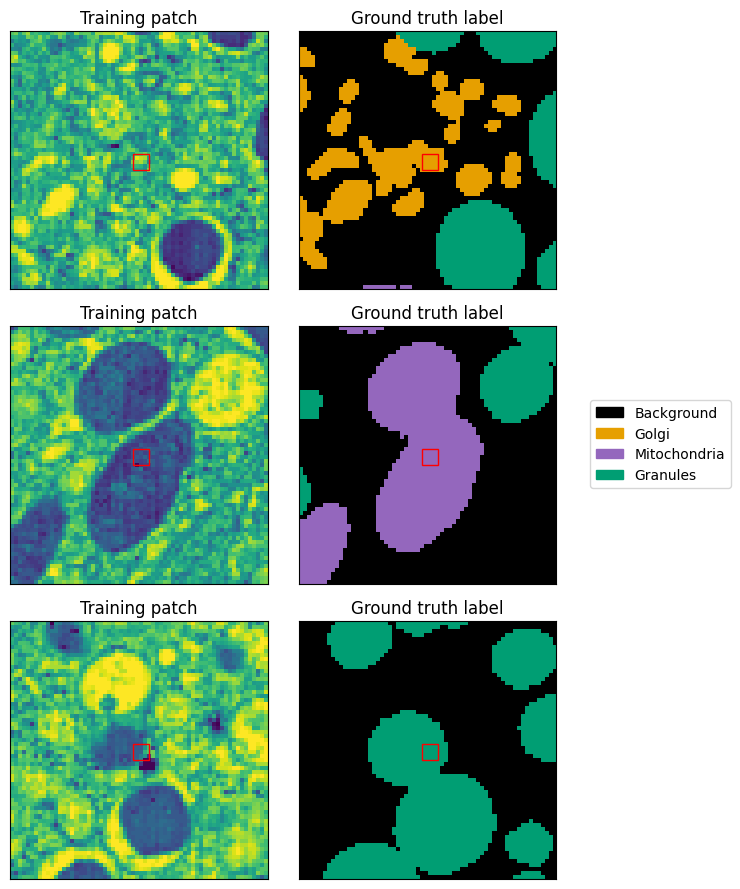

In [4]:
img_lbl = 'Training patch'
gt_lbl = 'Ground truth label'
i, j, k = np.random.randint(0, sample_size, 3)
p.plot_wo_b((golgi_samples[i], img_lbl, (pad_size, pad_size, centre_size)),\
        (golgi_lbl[i], gt_lbl, (pad_size, pad_size, centre_size)),\
        (mito_samples[j], img_lbl, (pad_size, pad_size, centre_size)),\
        (mito_lbl[j], gt_lbl, (pad_size, pad_size, centre_size)),\
        (gra_samples[k], img_lbl, (pad_size, pad_size, centre_size)),\
        (gra_lbl[k], gt_lbl, (pad_size, pad_size, centre_size)),
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l', 'imshow', 'imshow_l']
        )

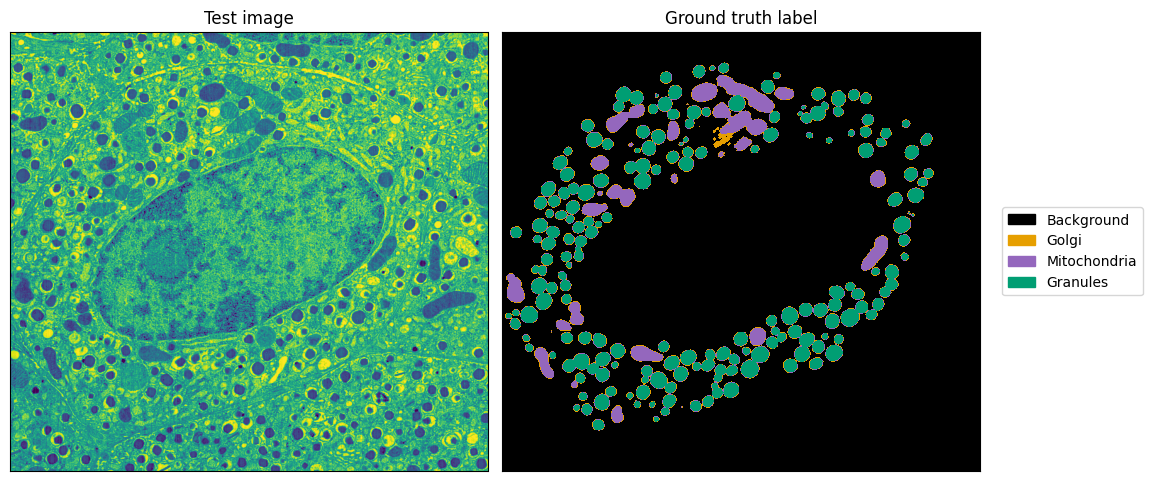

In [5]:
img_lbl = 'Test image'
i = np.random.randint(0, len(test_images))
p.plot_wo_b((test_images[i], img_lbl, False),\
        (test_labels[i], gt_lbl, False),\
        plot_types=['imshow', 'imshow_l'],
        box_size=5
        )

## Extracting latent space from Encoder

In [6]:
golgi_mu, mitochondria_mu, granule_mu = np.empty((0, 43008)), np.empty((0, 43008)), np.empty((0, 43008))
FE = FeatureExtractor(model, patch_size, centre_size)
for idx in range(sample_size):
    mu = FE.get_feature_maps(golgi_samples[idx])
    golgi_mu = np.vstack([golgi_mu, mu])
    mu = FE.get_feature_maps(mito_samples[idx])
    mitochondria_mu = np.vstack([mitochondria_mu, mu])
    mu = FE.get_feature_maps(gra_samples[idx])
    granule_mu = np.vstack([granule_mu, mu])
train_mu = np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0)

## t-SNE on latent space of train samples

In [7]:
tsne = []
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate="auto",
    metric="euclidean",
    n_iter=10000,
).fit(train_mu)
golgi = tsne[:sample_size]
mitochondria = tsne[sample_size:2*sample_size]
granule = tsne[2*sample_size:]

In [8]:
while True: 
        patch, label, y, x = dp.get_random_patch(test_images[i], test_labels[i], patch_size)
        centre = label[pad_size:pad_size+centre_size,pad_size:pad_size+centre_size]
        if 0 not in centre and np.unique(centre).size == 1:
                break
feature_map = FE.get_feature_maps(patch)
feature_map = np.expand_dims(feature_map, axis=0)

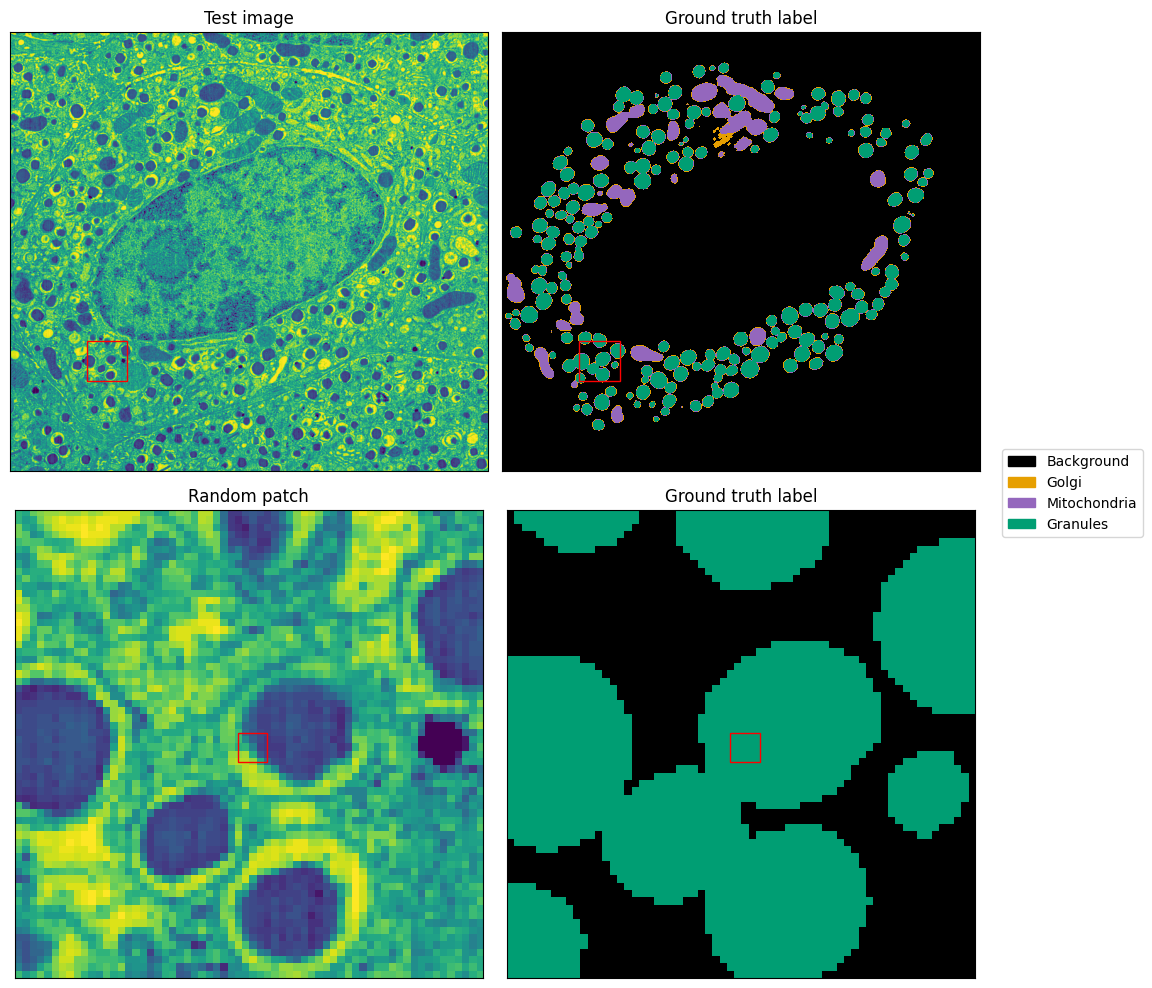

In [9]:

p.plot_wo_b( (test_images[i], img_lbl, (y, x, patch_size)),\
        (test_labels[i], gt_lbl, (y, x, patch_size)),\
        (patch, "Random patch", (pad_size, pad_size, centre_size)),\
        (label, gt_lbl, (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l'],
        box_size=5
        )
test_label = np.unique(centre)[0]

In [10]:
dp.save_pickle(f"train_mu_{i}", train_mu)
dp.save_pickle(f"feature_map_{y}_{x}", feature_map)

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(train_mu)
labels_kmean = kmeans.labels_
unique_labels, counts = np.unique(labels_kmean, return_counts=True)
print(unique_labels, counts)

[0 1 2] [131 131 131]


In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture


pca = PCA(n_components=200)
x_mu_reduced = pca.fit_transform(train_mu)
new_point_reduced = pca.transform(feature_map.reshape(1, -1))

scaler = StandardScaler()
mus_normalized = scaler.fit_transform(x_mu_reduced)

gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=0)
gmm.fit(mus_normalized)
new_mu_normalized = scaler.transform(new_point_reduced.reshape(1, -1))

probs = gmm.predict_proba(new_mu_normalized)
print(probs)

[[1.90822935e-261 1.55006944e-011 1.00000000e+000]]


In [25]:
labels_gmm = gmm.predict(mus_normalized)

In [28]:
unique_labels, counts = np.unique(labels_gmm, return_counts=True)
print(unique_labels, counts)

[0 1 2] [  1 108 284]


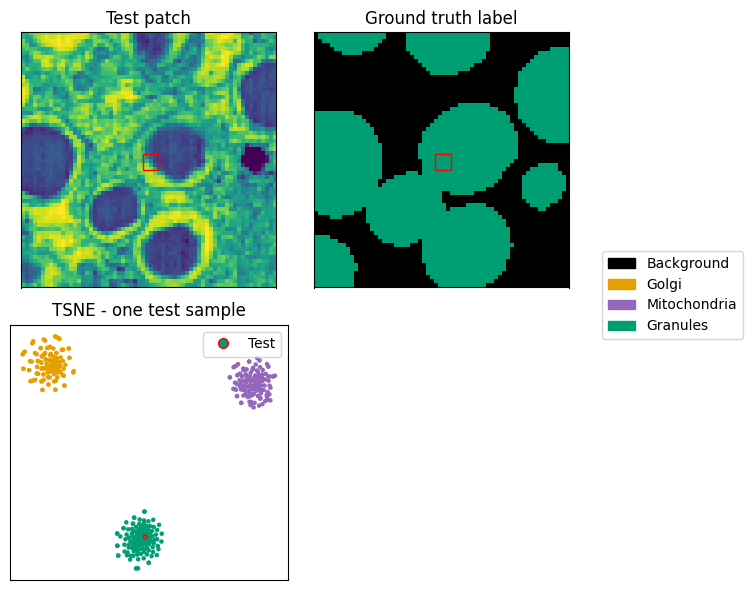

In [24]:
test_embedding = tsne.transform(feature_map)
point_size = 5
p.plot_wo_b( (patch, "Test patch", (pad_size, pad_size, centre_size)),\
        (label, gt_lbl, (pad_size, pad_size, centre_size)),\
        ([golgi, mitochondria, granule, test_embedding], "TSNE - one test sample",\
                 [([1]*sample_size,point_size), ([2]*sample_size,point_size),\
                   ([3]*sample_size,point_size), ([test_label],point_size)]),\
        plot_types=['imshow', 'imshow_l', 'scatter'],
        )

In [ ]:
begin = 250
end = 414
p.plot_wo_b((test_images[i][begin:end, begin:end], "Test image", False),\
            (test_labels[i][begin:end, begin:end], "GT label", False),\
            plot_types=['imshow', 'imshow_l'])

In [ ]:
h, w = test_images[i][begin:end, begin:end].shape
new_h, new_w = h - patch_size + 1, w - patch_size + 1
feature_maps = np.zeros((new_h, new_w))
all_patches, all_labels = dp.get_all_patches(test_images[i][begin:end, begin:end], test_labels[i][begin:end, begin:end], patch_size, stride=1)
idx = 0
for y in tqdm(range(new_h)):
    for x in range(new_w):
        mu = FE.get_feature_maps(all_patches[idx])
        feature_maps[y][x] = FE.get_closest(train_mu, mu)
        idx += 1

In [ ]:
plt.imshow(feature_maps)

In [ ]:
dp.save_pickle(f"feature_maps_{i}th_test_sample.pkl", feature_maps)
feature_maps = dp.load_pickle(f"feature_maps_{i}th_test_sample.pkl")

In [ ]:
result = np.where(test_labels[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101] != 0, feature_maps, 0)

In [ ]:
p.plot_wo_b( (test_images[i][begin:end, begin:end], "Input", (pad_size, pad_size, 101)),\
        (test_labels[i][begin:end, begin:end], "GT label", (pad_size, pad_size, 101)),\
        (test_images[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101], "Input cropped", False),\
        (test_labels[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101], "GT label cropped", False),\
        (feature_maps, "Prediction", False),\
        (result, "Prediction with background", False),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l', 'imshow_l', 'imshow_l'])

In [ ]:
np.unique(feature_maps, return_counts=True)

## Agglomerative Hierarchical Clustering

In [37]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import numpy as np

# Assuming X_train is your high-dimensional training data
X_train = train_mu  # Replace with your data

# Perform Agglomerative Clustering
num_clusters = 3
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
agg_labels = agg_clustering.fit_predict(X_train)
agg_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

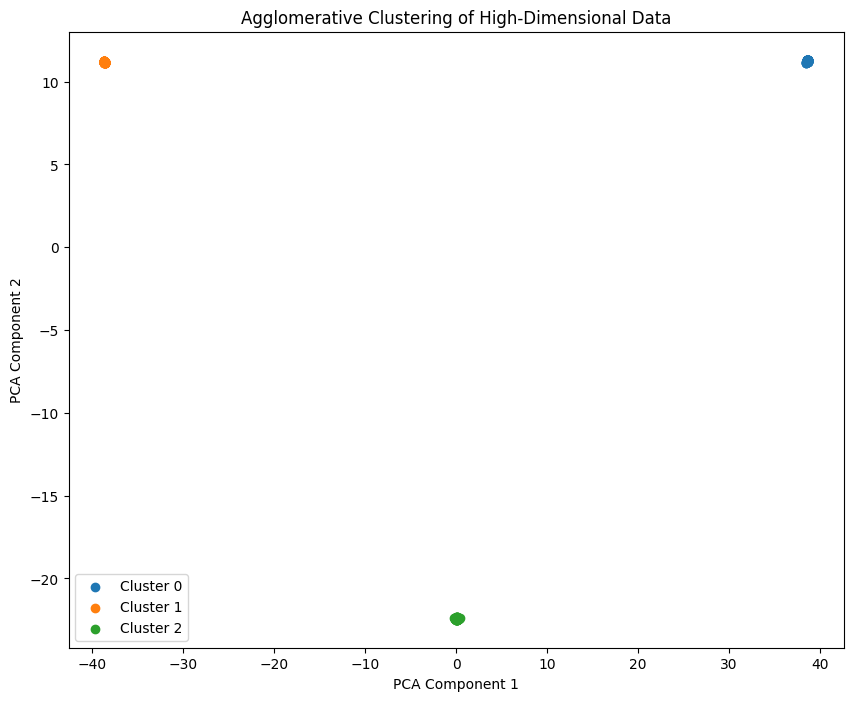

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)

# Scatter plot of the reduced data, colored by cluster labels
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster_points = X_train_reduced[agg_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title("Agglomerative Clustering of High-Dimensional Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [35]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assuming true_labels are your known labels
true_labels = np.array([0] * 131 + [1] * 131 + [2] * 131)  # Replace with your true labels

# Evaluate Agglomerative clustering
agg_ari = adjusted_rand_score(true_labels, agg_labels)
agg_nmi = normalized_mutual_info_score(true_labels, agg_labels)

print("Agglomerative Clustering ARI:", agg_ari)
print("Agglomerative Clustering NMI:", agg_nmi)


Agglomerative Clustering ARI: 1.0
Agglomerative Clustering NMI: 1.0


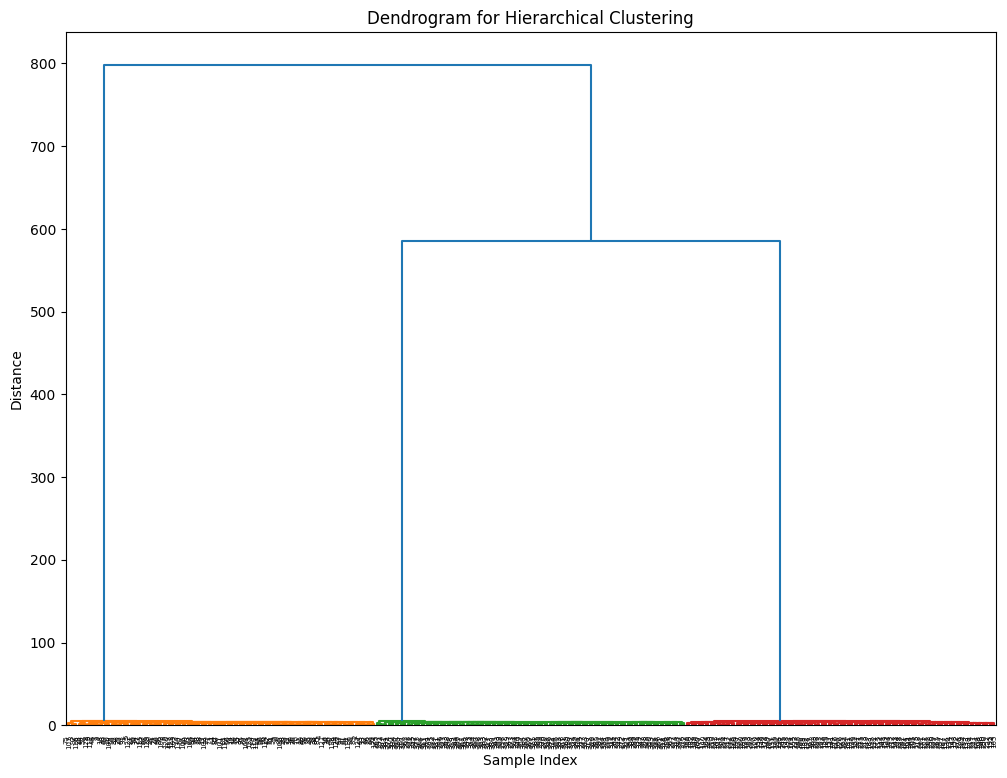

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering and get the linkage matrix
Z = linkage(X_train, 'ward')

# Plot the dendrogram
plt.figure(figsize=(12, 9))
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()
